#### 1. fractured/non_fractured Ìè¥Îçî ÎÇ¥Ïùò Í∞Å Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎì§ÏùÑ Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥ÑÎ°ú Î∂ÑÎ•òÌïòÏßÄ ÏïäÍ≥† ÌïúÎ≤àÏóê ÌïôÏäµ

In [ ]:
import cv2, json, numpy as np, torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import os

# Í≤ΩÎ°ú 
ROOT_IMG = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/data/images")
ANNO_JSON = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/data/Annotations/COCO JSON/COCO_fracture_masks.json")

SIZE     = (512, 512)
BATCH    = 4
EPOCHS   = 12
LR       = 1e-4
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA:", DEVICE)

CUDA: cuda


In [ ]:
class FractureSegDataset(Dataset):
    """ Fractured / Non_fractured Ïù¥ÎØ∏ÏßÄ ‚Üí (X, GT mask) """
    def __init__(self, split: str, coco: COCO, tf=None, with_mask=True):
        self.paths  = []                 # Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú
        self.labels = []                 # 1=fractured, 0=normal
        self.tf     = tf
        self.with_mask = with_mask
        # Ïù¥ÎØ∏ÏßÄ ÌÉêÏÉâ
        for cls, lab in [("Fractured",1), ("Non_fractured",0)]:
            for p in (ROOT_IMG/split/cls).glob("*.jpg"):
                self.paths.append(p); self.labels.append(lab)
        # COCO ÎÇ¥Î∂Ä dict (file_name ‚Üí anns)
        self.file2anns = {}
        for ann in coco.dataset["annotations"]:
            fn = coco.imgs[ann["image_id"]]["file_name"]
            self.file2anns.setdefault(fn, []).append(ann)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img_path, lab = self.paths[idx], self.labels[idx]
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        h0, w0 = img.shape[:2]

        # Í∏∞Î≥∏ ÎßàÏä§ÌÅ¨ (Ï†ÑÎ∂Ä 0)
        mask = np.zeros((h0, w0), np.uint8)
        if lab == 1 and self.with_mask:          # fractured & mask ÏÇ¨Ïö©
            for ann in self.file2anns.get(img_path.name, []):
                for seg in ann["segmentation"]:
                    pts = np.array(seg).reshape(-1,2).astype(np.int32)
                    cv2.fillPoly(mask, [pts], 1)

        img  = cv2.resize(img,  SIZE)
        mask = cv2.resize(mask, SIZE, interpolation=cv2.INTER_NEAREST)

        if self.tf:
            aug = self.tf(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        return img, mask.unsqueeze(0).float()    # X:[3,H,W]  y:[1,H,W]


In [ ]:
tf_train = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.HorizontalFlip(), A.RandomRotate90(),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
tf_val   = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

coco = COCO(str(ANNO_JSON))

train_dl = DataLoader(FractureSegDataset("train", coco, tf_train, with_mask=True),
                      batch_size=BATCH, shuffle=True,  num_workers=2)
val_dl   = DataLoader(FractureSegDataset("valid", coco, tf_val,   with_mask=True),
                      batch_size=BATCH, shuffle=False, num_workers=2)
test_dl  = DataLoader(FractureSegDataset("test",  coco, tf_val,   with_mask=False),
                      batch_size=1,     shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/tmp/ipykernel_4065222/2001014471.py:4: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.3),


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
                 in_channels=3, classes=1, activation=None).to(DEVICE)

bce  = nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode="binary")
def loss_fn(logits, mask):
    return bce(logits, mask) + dice(torch.sigmoid(logits), mask)

opt = optim.Adam(model.parameters(), lr=LR)

In [ ]:
def iou(pred, gt, thr=0.5, eps=1e-6):
    p = (pred>thr).float(); g = gt.float()
    inter = (p*g).sum(); union = p.sum()+g.sum()-inter
    return ((inter+eps)/(union+eps)).item()

for ep in range(1, EPOCHS+1):
    # Train
    model.train(); t_loss=0
    for X,y in train_dl:
        X,y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(); logit = model(X)
        loss = loss_fn(logit,y); loss.backward(); opt.step()
        t_loss += loss.item()
    # Val
    model.eval(); v_iou=v_dice=0; n=0
    with torch.no_grad():
        for X,y in val_dl:
            X,y = X.to(DEVICE), y.to(DEVICE)
            pr = torch.sigmoid(model(X))
            for b in range(X.size(0)):
                v_iou  += iou(pr[b,0], y[b,0])
                v_dice += dice(pr[b], y[b]).item(); n+=1
    print(f"Ep{ep:02d}  TrainLoss {t_loss/len(train_dl):.4f}  "
          f"Val IoU {v_iou/n:.4f}  Dice {1-v_dice/n:.4f}")

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep01  TrainLoss 0.7115  Val IoU 0.4332  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep02  TrainLoss 0.5589  Val IoU 0.6639  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep03  TrainLoss 0.5369  Val IoU 0.6754  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep04  TrainLoss 0.5272  Val IoU 0.8108  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep05  TrainLoss 0.5381  Val IoU 0.8124  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep06  TrainLoss 0.5427  Val IoU 0.7961  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep07  TrainLoss 0.5489  Val IoU 0.8238  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep08  TrainLoss 0.5372  Val IoU 0.8238  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep09  TrainLoss 0.5510  Val IoU 0.8244  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep10  TrainLoss 0.5227  Val IoU 0.8295  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep11  TrainLoss 0.5392  Val IoU 0.8288  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep12  TrainLoss 0.5306  Val IoU 0.8319  Dice 0.8255


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44264 (\N{HANGUL SYLLABLE GOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48744 (\N{HANGUL SYLLABLE BBAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPyt

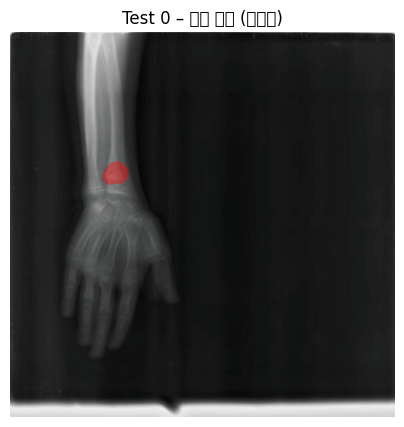

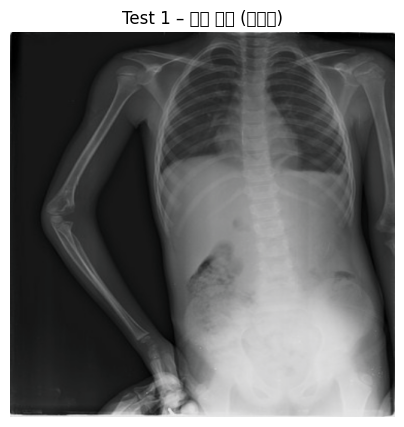

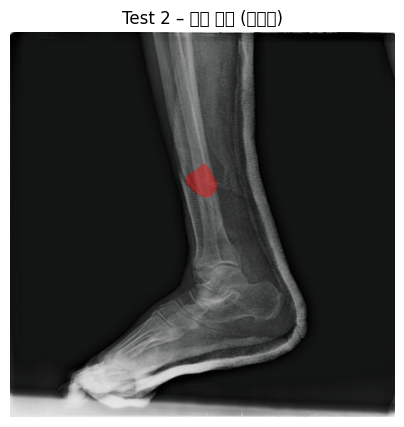

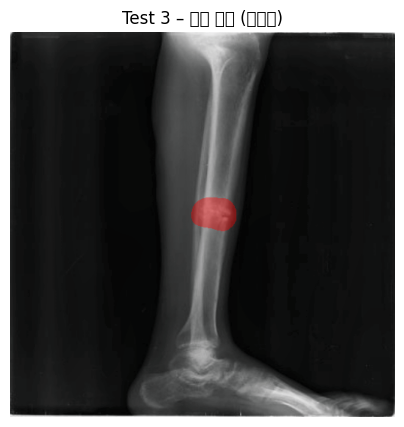

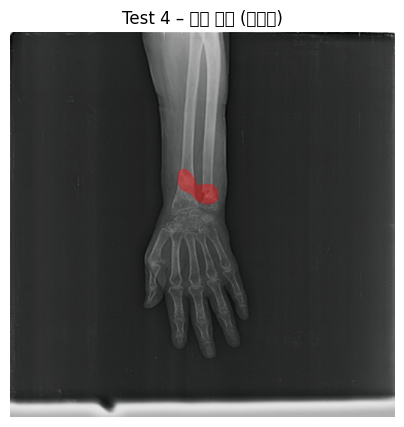

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å!  Ï†ÄÏû• ÏúÑÏπò: /home/a202152010/Í≥®Ï†àÏßÑÎã®/visualization_results/test


In [ ]:
# Test ÏòàÏ∏° ÎßàÏä§ÌÅ¨ ÏãúÍ∞ÅÌôî & Ï†ÄÏû• 
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# Ï†ÄÏû•Í≤ΩÎ°ú ÏßÄÏ†ï ‚îÄ ÌîÑÎ°úÏ†ùÌä∏ Î£®Ìä∏ Í∏∞Ï§Ä
SAVE_DIR = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/visualization_results/test")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def overlay(img, mask, color=(255, 0, 0), alpha=0.4):
    """RGB img(H,W,3), mask(H,W) 0/1 ‚Üí Îπ®Í∞Ñ Ïò§Î≤ÑÎ†àÏù¥"""
    h, w = img.shape[:2]
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    color_mask = np.zeros_like(img); color_mask[:] = color
    return np.where(mask[..., None], cv2.addWeighted(img, 1-alpha, color_mask, alpha, 0), img)

model.eval()
for idx, (X, _) in enumerate(test_dl):
    X = X.to(DEVICE)
    with torch.no_grad():
        prob = torch.sigmoid(model(X))[0, 0].cpu().numpy()
    pred = (prob > 0.5).astype(np.uint8)

    # ÏõêÎ≥∏ ÌîΩÏÖÄÎ°ú Î≥µÏõê (Imagenet Ïó≠Ï†ïÍ∑úÌôî)
    img = X[0].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
    img = (img * 255).astype(np.uint8)

    viz = overlay(img, pred)
    out_file = SAVE_DIR / f"test_{idx:04d}.png"
    cv2.imwrite(str(out_file), cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

    # Ïïû 5Ïû•ÏùÄ Î∞îÎ°ú Î≥¥Ïó¨Ï£ºÍ∏∞
    if idx < 5:
        plt.figure(figsize=(5,5))
        plt.imshow(viz); plt.axis('off')
        plt.title(f"Test {idx} ‚Äì Fractured (red)")
        plt.show()

print(f"ÏãúÍ∞ÅÌôî ÏôÑÎ£å!  Ï†ÄÏû• ÏúÑÏπò: {SAVE_DIR.resolve()}")


In [ ]:
# ‚îÄ‚îÄ Test ÏÑ∏Ìä∏: Í≥®Ï†à Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•ò Ï†ïÌôïÎèÑ ÌèâÍ∞Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np, torch, cv2, albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# 1. Test DataLoaderÎäî ÏïûÏÑú ÎßåÎì† test_dl Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©
# 2. ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï
PROB_THRESH  = 0.5     # ÌîΩÏÖÄÏùÑ 1Î°ú Î≥º ÌôïÎ•† ÏûÑÍ≥ÑÍ∞í
AREA_THRESH  = 0.001   # Ï†ÑÏ≤¥ ÌîΩÏÖÄ ÎåÄÎπÑ Í≥®Ï†à ÌîΩÏÖÄ ÎπÑÏú®, 0.1% Ïù¥ÏÉÅÏù¥Î©¥ 'Í≥®Ï†à'

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for (X, _), path_dict in zip(test_dl, test_dl.dataset.paths):
        # ‚îÄ ÌòÑÏû¨ Î∞∞ÏπòÎäî 1Ïû•Ïù¥ÎØÄÎ°ú X[0]
        X = X.to(DEVICE)
        prob = torch.sigmoid(model(X))[0, 0].cpu().numpy()      # [H,W]
        pred_mask = prob > PROB_THRESH
        frac_ratio = pred_mask.mean()                           # Í≥®Ï†à ÌîΩÏÖÄ ÎπÑÏú®
        pred_label = 1 if frac_ratio > AREA_THRESH else 0
        y_pred.append(pred_label)

        # ‚îÄ Ìè¥Îçî Ïù¥Î¶ÑÏúºÎ°ú Ï∞∏Í∞í ÎùºÎ≤® ÏñªÍ∏∞
        img_path = path_dict  # Dataset ÌÅ¥ÎûòÏä§ÏóêÏÑú Ï†ÄÏû•Ìï¥ Îëî Ïã§Ï†ú Í≤ΩÎ°ú
        true_label = 1 if "Fractured" in img_path.parts else 0
        y_true.append(true_label)

# 3. ÏÑ±Îä• ÏßÄÌëú Ï∂úÎ†•
print("=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["normal","fracture"]))
print(f"Accuracy : {accuracy_score(y_true, y_pred):.3%}")

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


=== Confusion Matrix ===
[[503   2]
 [ 67  41]]

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.88      1.00      0.94       505
    fracture       0.95      0.38      0.54       108

    accuracy                           0.89       613
   macro avg       0.92      0.69      0.74       613
weighted avg       0.89      0.89      0.87       613

Accuracy : 88.744%


### U-Net Í∞úÏÑ† 
 - Ïã§Ï†ú ÏùòÎ£å ÏßÑÎã®ÏóêÏÑúÎäî Í≥®Ï†à ÎàÑÎùΩ Î∞©ÏßÄÍ∞Ä Îçî Ï§ëÏöîÌï® -> Ïû¨ÌòÑÏú® ÎÜíÏù¥Í∏∞ (Ï¶ùÍ∞ï, Í≥®Ï†à ÏÉòÌîå Oversampling, ÏûÑÍ≥ÑÍ∞í ÎÇÆÏ∂§)

In [ ]:
import cv2, json, torch, torch.nn as nn, torch.optim as optim
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

ROOT_IMG  = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/data/images")
ANNO_JSON = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/data/Annotations/COCO JSON/COCO_fracture_masks.json")

SIZE   = (512, 512)
BATCH  = 4
EPOCHS = 12
LR     = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA device:", DEVICE)

CUDA device: cuda


In [ ]:
class FractureSegDataset(Dataset):
    def __init__(self, split, coco: COCO, tf=None, with_mask=True):
        self.paths, self.labels = [], []           # 1=Í≥®Ï†à, 0=Ï†ïÏÉÅ
        for cls, lab in [("Fractured",1), ("Non_fractured",0)]:
            for p in (ROOT_IMG/split/cls).glob("*.jpg"):
                self.paths.append(p)
                self.labels.append(lab)
        self.tf, self.with_mask = tf, with_mask
        self.file2anns = {}
        for ann in coco.dataset["annotations"]:
            fn = coco.imgs[ann["image_id"]]["file_name"]
            self.file2anns.setdefault(fn, []).append(ann)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p, lab = self.paths[idx], self.labels[idx]
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        h,w  = img.shape[:2]
        mask = np.zeros((h,w), np.uint8)

        if lab==1 and self.with_mask:              # Í≥®Ï†à Ïù¥ÎØ∏ÏßÄÏùº ÎïåÎßå ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
            for ann in self.file2anns.get(p.name, []):
                for seg in ann["segmentation"]:
                    pts = np.array(seg).reshape(-1,2).astype(np.int32)
                    cv2.fillPoly(mask, [pts], 1)

        img  = cv2.resize(img,  SIZE)
        mask = cv2.resize(mask, SIZE, interpolation=cv2.INTER_NEAREST)

        if self.tf:
            aug = self.tf(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        return img, mask.unsqueeze(0).float() 

In [ ]:
tf_train = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.RandomGamma(gamma_limit=(80,120), p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(10.0,50.0), p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                       rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
tf_val = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

coco = COCO(str(ANNO_JSON))

train_ds = FractureSegDataset("train", coco, tf_train, with_mask=True)
val_ds   = FractureSegDataset("valid", coco, tf_val,   with_mask=True)
test_ds  = FractureSegDataset("test",  coco, tf_val,   with_mask=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/tmp/ipykernel_4065222/1946705008.py:9: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),


In [ ]:
# Oversampling Í∞ÄÏ§ëÏπò 3Î∞∞Î∞∞
weights = [3 if l==1 else 1 for l in train_ds.labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds,  batch_size=1,     shuffle=False)

print(f"Train {len(train_ds)} | Val {len(val_ds)} | Test {len(test_ds)}")

Train 2857 | Val 613 | Test 613


In [ ]:
from segmentation_models_pytorch.losses import FocalLoss
model = smp.Unet("resnet34", encoder_weights="imagenet",
                 in_channels=3, classes=1, activation=None).to(DEVICE)

bce   = nn.BCEWithLogitsLoss()
dice  = smp.losses.DiceLoss(mode="binary")
focal = FocalLoss(mode="binary", gamma=2.0)        # FN Ìå®ÎÑêÌã∞ Í∞ïÌôî

def loss_fn(logit, mask):
    prob = torch.sigmoid(logit)
    return 0.4*bce(logit, mask) + 0.4*dice(prob, mask) + 0.2*focal(prob, mask)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
def iou(pred, gt, thr=0.5, eps=1e-6):
    p = (pred>thr).float(); g = gt.float()
    inter = (p*g).sum(); union = p.sum()+g.sum()-inter
    return ((inter+eps)/(union+eps)).item()

for ep in range(1, EPOCHS+1):
    # --- Train
    model.train(); train_loss=0
    for X,y in train_dl:
        X,y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logit = model(X)
        loss = loss_fn(logit, y); loss.backward(); optimizer.step()
        train_loss += loss.item()

    # --- Val
    model.eval(); v_iou=v_dice=n=0
    with torch.no_grad():
        for X,y in val_dl:
            X,y = X.to(DEVICE), y.to(DEVICE)
            prob = torch.sigmoid(model(X))
            for b in range(X.size(0)):
                v_iou  += iou(prob[b,0], y[b,0])
                v_dice += dice(prob[b], y[b]).item()
                n += 1
    print(f"Ep{ep:02d}  TrainLoss {train_loss/len(train_dl):.4f}  "
          f"Val IoU {v_iou/n:.4f}  Dice {1-v_dice/n:.4f}")

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep01  TrainLoss 0.4939  Val IoU 0.7814  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep02  TrainLoss 0.3968  Val IoU 0.8238  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep03  TrainLoss 0.3807  Val IoU 0.8239  Dice 0.8254


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep04  TrainLoss 0.3784  Val IoU 0.8024  Dice 0.8255


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep05  TrainLoss 0.3792  Val IoU 0.7864  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep06  TrainLoss 0.3857  Val IoU 0.7680  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep07  TrainLoss 0.3847  Val IoU 0.7951  Dice 0.8257


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Ep08  TrainLoss 0.3805  Val IoU 0.8223  Dice 0.8257


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Ep09  TrainLoss 0.3846  Val IoU 0.8385  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep10  TrainLoss 0.3767  Val IoU 0.8294  Dice 0.8256


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Ep11  TrainLoss 0.3782  Val IoU 0.8467  Dice 0.8257


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Ep12  TrainLoss 0.3780  Val IoU 0.7845  Dice 0.8258


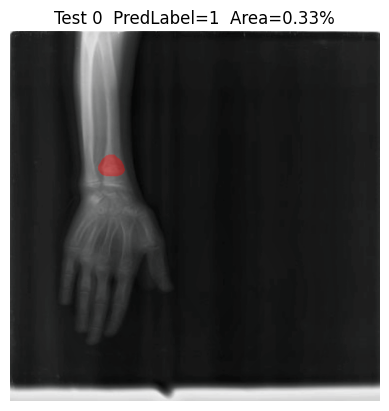

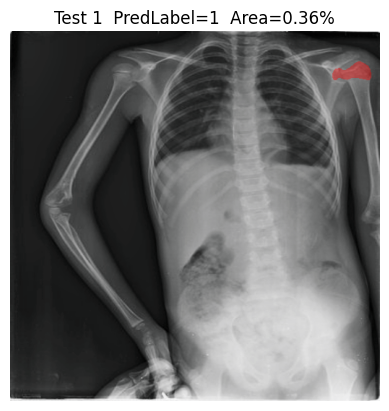

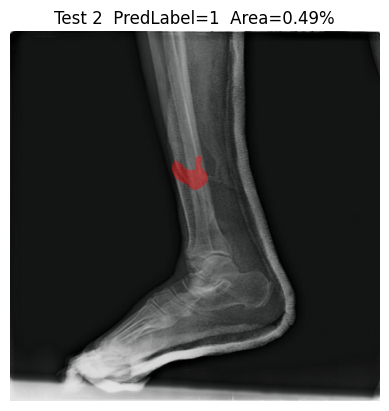

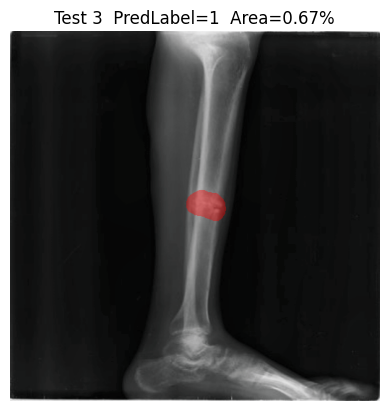

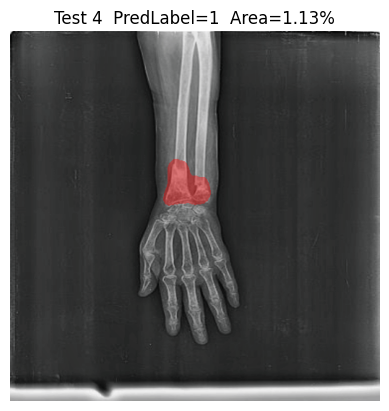

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


ÏãúÍ∞ÅÌôî Î∞è PNG Ï†ÄÏû• ÏôÑÎ£å: /home/a202152010/Í≥®Ï†àÏßÑÎã®/visualization_results/unet_test


In [ ]:
SAVE_DIR = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/visualization_results/unet_test")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

PROB_THRESH = 0.4      # ÎÇÆÏ∂ò ÏûÑÍ≥ÑÍ∞í
AREA_THRESH = 0.0005   # 0.05 %

def overlay(img, mask, color=(255,0,0), alpha=0.4):
    h,w = img.shape[:2]
    mask = cv2.resize(mask, (w,h), interpolation=cv2.INTER_NEAREST)
    clr  = np.zeros_like(img); clr[:] = color
    return np.where(mask[...,None], cv2.addWeighted(img,1-alpha,clr,alpha,0), img)

model.eval()
for idx, (X, _) in enumerate(test_dl):
    X = X.to(DEVICE)
    with torch.no_grad():
        prob = torch.sigmoid(model(X))[0,0].cpu().numpy()
    pred = prob > PROB_THRESH
    ratio = pred.mean()
    pred_label = 1 if ratio > AREA_THRESH else 0   # 1=Í≥®Ï†àÎ°ú Î∂ÑÎ•ò

    # ÏõêÎ≥∏ Î≥µÏõê
    img = X[0].cpu().permute(1,2,0).numpy()
    img = np.clip(img*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
    img_uint8 = (img*255).astype(np.uint8)
    viz = overlay(img_uint8, pred.astype(np.uint8))
    cv2.imwrite(str(SAVE_DIR/f"unet_{idx:04d}_{pred_label}.png"),
                cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

    if idx < 5:              # Ïïû 5Ïû•ÏùÄ ÎÖ∏Ìä∏Î∂ÅÏóê ÌëúÏãú
        plt.imshow(viz); plt.axis('off')
        plt.title(f"Test {idx}  PredLabel={pred_label}  Area={ratio*100:.2f}%")
        plt.show()

print("ÏãúÍ∞ÅÌôî Î∞è PNG Ï†ÄÏû• ÏôÑÎ£å:", SAVE_DIR)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_true, y_pred = [], []
for p in SAVE_DIR.glob("unet_*.png"):
    # ÌååÏùºÎ™ÖÏóê '_1.png' ‚Üí Pred=1
    pred_label = 1 if p.stem.split('_')[-1]=='1' else 0
    if "Fractured" in p.name:    # Í≤ΩÎ°úÍ∞Ä ÏïÑÎãàÎùº ÌååÏùºÎ™ÖÎßåÏúºÎ°úÎäî Íµ¨Î∂Ñ Ïñ¥Î†§Ïö∞Î©¥ test_ds.paths ÏÇ¨Ïö©
        true_label = 1
    elif "Non_fractured" in p.name:
        true_label = 0
    else:
        # fallback: Ïù¥ÎØ∏ test_ds ÏàúÏÑúÎåÄÎ°ú Îß§Ìïë
        idx = int(p.stem.split('_')[1])
        true_label = 1 if "Fractured" in test_ds.paths[idx].parts else 0
    y_pred.append(pred_label); y_true.append(true_label)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["normal","fracture"]))
print("Accuracy:", accuracy_score(y_true, y_pred))

=== Confusion Matrix ===
[[467  38]
 [ 27  81]]

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.95      0.92      0.93       505
    fracture       0.68      0.75      0.71       108

    accuracy                           0.89       613
   macro avg       0.81      0.84      0.82       613
weighted avg       0.90      0.89      0.90       613

Accuracy: 0.8939641109298532


# Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥Ñ Í≥®Ï†à ÏßÑÎã® U-Net Î™®Îç∏
Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÌï†ÌïòÏó¨ Í∞ÅÍ∞Å Ï†ÑÏö© U-Net Î™®Îç∏ÏùÑ ÌõàÎ†®Ìï©ÎãàÎã§.

## Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Ï†ÑÎûµ
1. CSV ÌååÏùºÏóêÏÑú Î∂ÄÏúÑÎ≥Ñ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î°úÎìú
2. Í∞Å Î∂ÄÏúÑÎ≥ÑÎ°ú Ïù¥ÎØ∏ÏßÄ ÌïÑÌÑ∞ÎßÅ
3. Î∂ÄÏúÑÎ≥Ñ train/valid/test Î∂ÑÌï†
4. Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌõàÎ†® Î∞è ÌèâÍ∞Ä

In [ ]:
import pandas as pd
import cv2, json, numpy as np, torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

ROOT_IMG = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/data/images")
ANNO_JSON = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/data/Annotations/COCO JSON/COCO_fracture_masks.json")
CSV_PATH = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/data/dataset.csv")
RESULTS_DIR = Path("/home/a202152010/Í≥®Ï†àÏßÑÎã®/bodypart_results")
RESULTS_DIR.mkdir(exist_ok=True)

# ‚îÄ‚îÄ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ‚îÄ‚îÄ
SIZE = (512, 512)
BATCH = 4
EPOCHS = 15
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"üöÄ Device: {DEVICE}")
print(f"üìÅ Results directory: {RESULTS_DIR}")

/home/a202152010/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/a202152010/.local/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/a202152010/.local/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


üöÄ Device: cuda
üìÅ Results directory: /home/a202152010/Í≥®Ï†àÏßÑÎã®/bodypart_results


In [ ]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Î∂ÑÏÑù
df = pd.read_csv(CSV_PATH)
print("=== Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤¥ ÌÜµÍ≥Ñ ===")
print(f"Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(df)}")
print(f"Í≥®Ï†à Ïù¥ÎØ∏ÏßÄ Ïàò: {df['fractured'].sum()}")
print(f"Ï†ïÏÉÅ Ïù¥ÎØ∏ÏßÄ Ïàò: {(df['fractured']==0).sum()}")

print("\n=== Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥Ñ Î∂ÑÌè¨ ===")
body_parts = ['hand', 'leg', 'hip', 'shoulder']
for part in body_parts:
    part_images = df[df[part] == 1]
    fractured_in_part = part_images[part_images['fractured'] == 1]
    print(f"{part.upper():>8}: Ï¥ù {len(part_images):4d}Í∞ú (Í≥®Ï†à {len(fractured_in_part):3d}Í∞ú, Ï†ïÏÉÅ {len(part_images)-len(fractured_in_part):3d}Í∞ú)")

print("\n=== Mixed Î∂ÄÏúÑ ÌôïÏù∏ ===")
mixed_count = df['mixed'].sum()
print(f"Mixed Î∂ÄÏúÑ: {mixed_count}Í∞ú")

# Í∞Å Ïù¥ÎØ∏ÏßÄÍ∞Ä Ïñ¥Îñ§ Î∂ÄÏúÑÏóê ÏÜçÌïòÎäîÏßÄ ÌôïÏù∏
df['body_part'] = 'unknown'
for part in body_parts:
    df.loc[df[part] == 1, 'body_part'] = part

print(f"\nÎØ∏Î∂ÑÎ•ò Ïù¥ÎØ∏ÏßÄ Ïàò: {(df['body_part'] == 'unknown').sum()}")

=== Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÑÏ≤¥ ÌÜµÍ≥Ñ ===
Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: 4083
Í≥®Ï†à Ïù¥ÎØ∏ÏßÄ Ïàò: 717
Ï†ïÏÉÅ Ïù¥ÎØ∏ÏßÄ Ïàò: 3366

=== Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥Ñ Î∂ÑÌè¨ ===
    HAND: Ï¥ù 1538Í∞ú (Í≥®Ï†à 438Í∞ú, Ï†ïÏÉÅ 1100Í∞ú)
     LEG: Ï¥ù 2273Í∞ú (Í≥®Ï†à 263Í∞ú, Ï†ïÏÉÅ 2010Í∞ú)
     HIP: Ï¥ù  338Í∞ú (Í≥®Ï†à  63Í∞ú, Ï†ïÏÉÅ 275Í∞ú)
SHOULDER: Ï¥ù  349Í∞ú (Í≥®Ï†à  63Í∞ú, Ï†ïÏÉÅ 286Í∞ú)

=== Mixed Î∂ÄÏúÑ ÌôïÏù∏ ===
Mixed Î∂ÄÏúÑ: 398Í∞ú

ÎØ∏Î∂ÑÎ•ò Ïù¥ÎØ∏ÏßÄ Ïàò: 0


In [ ]:
class BodyPartFractureDataset(Dataset):
    """Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥Ñ Í≥®Ï†à Îç∞Ïù¥ÌÑ∞ÏÖã"""
    def __init__(self, image_list, coco: COCO, split_type='train', tf=None, with_mask=True):
        self.image_list = image_list  # DataFrameÏùò subset
        self.split_type = split_type
        self.tf = tf
        self.with_mask = with_mask
        
        # COCO Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Îß§Ìïë
        self.file2anns = {}
        for ann in coco.dataset["annotations"]:
            fn = coco.imgs[ann["image_id"]]["file_name"]
            self.file2anns.setdefault(fn, []).append(ann)
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        row = self.image_list.iloc[idx]
        img_name = row['image_id']
        is_fractured = row['fractured']
        
        # Ïù¥ÎØ∏ÏßÄ ÌååÏùº Í≤ΩÎ°ú Ï∞æÍ∏∞
        img_path = None
        for split_dir in ['train', 'valid', 'test']:
            for class_dir in ['Fractured', 'Non_fractured']:
                potential_path = ROOT_IMG / split_dir / class_dir / img_name
                if potential_path.exists():
                    img_path = potential_path
                    break
            if img_path:
                break
        
        if not img_path or not img_path.exists():
            raise FileNotFoundError(f"Ïù¥ÎØ∏ÏßÄÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {img_name}")
        
        # Ïù¥ÎØ∏ÏßÄ Î°úÎìú
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
        mask = np.zeros((h, w), np.uint8)
        if is_fractured and self.with_mask:
            for ann in self.file2anns.get(img_name, []):
                for seg in ann["segmentation"]:
                    pts = np.array(seg).reshape(-1, 2).astype(np.int32)
                    cv2.fillPoly(mask, [pts], 1)
        
        # Î¶¨ÏÇ¨Ïù¥Ï¶à
        img = cv2.resize(img, SIZE)
        mask = cv2.resize(mask, SIZE, interpolation=cv2.INTER_NEAREST)
        
        # Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï
        if self.tf:
            aug = self.tf(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]
        
        return img, mask.unsqueeze(0).float()

print("BodyPartFractureDataset ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å")

‚úÖ BodyPartFractureDataset ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å


In [ ]:
def create_bodypart_splits(df, body_part, test_size=0.2, val_size=0.2, random_state=42):
    """ÌäπÏ†ï Ïã†Ï≤¥ Î∂ÄÏúÑÏùò Îç∞Ïù¥ÌÑ∞Î•º train/valid/testÎ°ú Î∂ÑÌï†"""
    
    # Ìï¥Îãπ Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
    part_data = df[df[body_part] == 1].copy()
    
    if len(part_data) == 0:
        print(f"{body_part} Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        return None, None, None
    
    print(f"\n=== {body_part.upper()} Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ===")
    print(f"Ï†ÑÏ≤¥ {body_part} Ïù¥ÎØ∏ÏßÄ: {len(part_data)}Í∞ú")
    
    # Í≥®Ï†à/Ï†ïÏÉÅÎ≥Ñ Î∂ÑÌï†
    fractured = part_data[part_data['fractured'] == 1]
    normal = part_data[part_data['fractured'] == 0]
    
    print(f"Í≥®Ï†à: {len(fractured)}Í∞ú, Ï†ïÏÉÅ: {len(normal)}Í∞ú")
    
    # Í∞ÅÍ∞Å train/val/test Î∂ÑÌï†
    def split_data(data, test_size, val_size):
        if len(data) < 3:  # ÏµúÏÜå 3Í∞úÎäî ÏûàÏñ¥Ïïº Î∂ÑÌï† Í∞ÄÎä•
            return data, pd.DataFrame(), pd.DataFrame()
        
        # Î®ºÏ†Ä train+valÍ≥º test Î∂ÑÌï†
        train_val, test = train_test_split(data, test_size=test_size, random_state=random_state)
        
        if len(train_val) < 2:
            return train_val, pd.DataFrame(), test
        
        # trainÍ≥º val Î∂ÑÌï†
        val_size_adjusted = val_size / (1 - test_size)  # ÎÇ®ÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÏùò ÎπÑÏú® Ï°∞Ï†ï
        train, val = train_test_split(train_val, test_size=val_size_adjusted, random_state=random_state)
        
        return train, val, test
    
    # Í≥®Ï†à Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
    if len(fractured) > 0:
        frac_train, frac_val, frac_test = split_data(fractured, test_size, val_size)
    else:
        frac_train = frac_val = frac_test = pd.DataFrame()
    
    # Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
    if len(normal) > 0:
        norm_train, norm_val, norm_test = split_data(normal, test_size, val_size)
    else:
        norm_train = norm_val = norm_test = pd.DataFrame()
    
    # Ìï©ÏπòÍ∏∞
    train_data = pd.concat([frac_train, norm_train], ignore_index=True)
    val_data = pd.concat([frac_val, norm_val], ignore_index=True)
    test_data = pd.concat([frac_test, norm_test], ignore_index=True)
    
    print(f"Î∂ÑÌï† Í≤∞Í≥º:")
    print(f"  Train: {len(train_data)}Í∞ú (Í≥®Ï†à: {(train_data['fractured']==1).sum()}Í∞ú)")
    print(f"  Valid: {len(val_data)}Í∞ú (Í≥®Ï†à: {(val_data['fractured']==1).sum()}Í∞ú)")
    print(f"  Test:  {len(test_data)}Í∞ú (Í≥®Ï†à: {(test_data['fractured']==1).sum()}Í∞ú)")
    
    return train_data, val_data, test_data

print(" Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å


In [ ]:
# Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏÑ§Ï†ï
tf_train = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.RandomGamma(gamma_limit=(80,120), p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(10.0,50.0), p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                       rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=30, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

tf_val = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# COCO Îç∞Ïù¥ÌÑ∞ Î°úÎìú
coco = COCO(str(ANNO_JSON))
print("COCO Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Î°úÎìú ÏôÑÎ£å")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
‚úÖ COCO Ïñ¥ÎÖ∏ÌÖåÏù¥ÏÖò Î°úÎìú ÏôÑÎ£å


In [ ]:
def train_bodypart_model(body_part, train_data, val_data, test_data):
    """ÌäπÏ†ï Ïã†Ï≤¥ Î∂ÄÏúÑÏóê ÎåÄÌïú U-Net Î™®Îç∏ ÌõàÎ†®"""
    
    print(f"\n{body_part.upper()} Î∂ÄÏúÑ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë")
    
    # Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    train_ds = BodyPartFractureDataset(train_data, coco, 'train', tf_train, True)
    val_ds = BodyPartFractureDataset(val_data, coco, 'val', tf_val, True)
    test_ds = BodyPartFractureDataset(test_data, coco, 'test', tf_val, False)
    
    # Oversampling (Í≥®Ï†à Îç∞Ïù¥ÌÑ∞ 3Î∞∞ Í∞ÄÏ§ëÏπò)
    weights = [3 if row['fractured']==1 else 1 for _, row in train_data.iterrows()]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    
    # Îç∞Ïù¥ÌÑ∞Î°úÎçî
    train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)
    
    # Î™®Îç∏ Ï¥àÍ∏∞Ìôî
    model = smp.Unet("resnet34", encoder_weights="imagenet",
                     in_channels=3, classes=1, activation=None).to(DEVICE)
    
    # ÏÜêÏã§ Ìï®Ïàò (FocalLoss Ï∂îÍ∞ÄÎ°ú FN Ìå®ÎÑêÌã∞ Í∞ïÌôî)
    bce = nn.BCEWithLogitsLoss()
    dice = smp.losses.DiceLoss(mode="binary")
    focal = smp.losses.FocalLoss(mode="binary", gamma=2.0)
    
    def loss_fn(logit, mask):
        prob = torch.sigmoid(logit)
        return 0.4*bce(logit, mask) + 0.4*dice(prob, mask) + 0.2*focal(prob, mask)
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # IoU Í≥ÑÏÇ∞ Ìï®Ïàò
    def iou(pred, gt, thr=0.5, eps=1e-6):
        p = (pred>thr).float(); g = gt.float()
        inter = (p*g).sum(); union = p.sum()+g.sum()-inter
        return ((inter+eps)/(union+eps)).item()
    
    # ÌõàÎ†® Î£®ÌîÑ
    best_val_iou = 0
    train_losses, val_ious, val_dices = [], [], []
    
    for ep in range(1, EPOCHS+1):
        # --- Train
        model.train()
        train_loss = 0
        for X, y in train_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logit = model(X)
            loss = loss_fn(logit, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # --- Validation
        model.eval()
        v_iou = v_dice = n = 0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(DEVICE), y.to(DEVICE)
                prob = torch.sigmoid(model(X))
                for b in range(X.size(0)):
                    v_iou += iou(prob[b,0], y[b,0])
                    v_dice += dice(prob[b], y[b]).item()
                    n += 1
        
        avg_train_loss = train_loss / len(train_dl)
        avg_val_iou = v_iou / n if n > 0 else 0
        avg_val_dice = 1 - v_dice / n if n > 0 else 0
        
        train_losses.append(avg_train_loss)
        val_ious.append(avg_val_iou)
        val_dices.append(avg_val_dice)
        
        print(f"Epoch {ep:02d}: Loss {avg_train_loss:.4f}, Val IoU {avg_val_iou:.4f}, Val Dice {avg_val_dice:.4f}")
        
        # Î≤†Ïä§Ìä∏ Î™®Îç∏ Ï†ÄÏû•
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), RESULTS_DIR / f"best_{body_part}_unet.pth")
    
    return model, train_losses, val_ious, val_dices, test_dl

print("‚úÖ Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌõàÎ†® Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

‚úÖ Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌõàÎ†® Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å


In [ ]:
def evaluate_bodypart_model(model, test_dl, body_part, prob_thresh=0.4, area_thresh=0.0005):
    """Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌèâÍ∞Ä Î∞è ÏãúÍ∞ÅÌôî"""
    
    print(f"\n{body_part.upper()} Î™®Îç∏ ÌèâÍ∞Ä Ï§ë...")
    
    # ÏãúÍ∞ÅÌôî Ï†ÄÏû• Í≤ΩÎ°ú
    viz_dir = RESULTS_DIR / f"{body_part}_visualizations"
    viz_dir.mkdir(exist_ok=True)
    
    def overlay(img, mask, color=(255,0,0), alpha=0.4):
        h, w = img.shape[:2]
        mask = cv2.resize(mask, (w,h), interpolation=cv2.INTER_NEAREST)
        clr = np.zeros_like(img); clr[:] = color
        return np.where(mask[...,None], cv2.addWeighted(img,1-alpha,clr,alpha,0), img)
    
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for idx, (X, _) in enumerate(test_dl):
            X = X.to(DEVICE)
            prob = torch.sigmoid(model(X))[0,0].cpu().numpy()
            pred_mask = prob > prob_thresh
            ratio = pred_mask.mean()
            pred_label = 1 if ratio > area_thresh else 0
            
            # Ground truth ÎùºÎ≤® (Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°úÏóêÏÑú Ï∂îÏ∂ú)
            test_img_info = test_dl.dataset.image_list.iloc[idx]
            true_label = test_img_info['fractured']
            
            y_pred.append(pred_label)
            y_true.append(true_label)
            
            # ÏãúÍ∞ÅÌôî
            img = X[0].cpu().permute(1,2,0).numpy()
            img = np.clip(img*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
            img_uint8 = (img*255).astype(np.uint8)
            viz = overlay(img_uint8, pred_mask.astype(np.uint8))
            
            # Ï†ÄÏû•
            img_name = test_img_info['image_id']
            cv2.imwrite(str(viz_dir / f"{body_part}_{idx:03d}_{img_name}"),
                       cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))
            
            # Ï≤òÏùå 3Í∞ú Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
            if idx < 3:
                plt.figure(figsize=(8,6))
                plt.imshow(viz)
                plt.axis('off')
                plt.title(f"{body_part.upper()} Test {idx}: True={true_label}, Pred={pred_label}\n"
                         f"Fracture Area: {ratio*100:.2f}%")
                plt.show()
    
    # ÏÑ±Îä• ÌèâÍ∞Ä
    print(f"\n=== {body_part.upper()} Î™®Îç∏ ÏÑ±Îä• ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fractured"]))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3%}")
    
    return y_true, y_pred

print("Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

‚úÖ Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å



üè• HAND Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏãúÏûë

=== HAND Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ===
Ï†ÑÏ≤¥ hand Ïù¥ÎØ∏ÏßÄ: 1538Í∞ú
Í≥®Ï†à: 438Í∞ú, Ï†ïÏÉÅ: 1100Í∞ú
Î∂ÑÌï† Í≤∞Í≥º:
  Train: 922Í∞ú (Í≥®Ï†à: 262Í∞ú)
  Valid: 308Í∞ú (Í≥®Ï†à: 88Í∞ú)
  Test:  308Í∞ú (Í≥®Ï†à: 88Í∞ú)

üöÄ HAND Î∂ÄÏúÑ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 01: Loss 0.7067, Val IoU 0.0000, Val Dice 0.7164


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 02: Loss 0.5333, Val IoU 0.4708, Val Dice 0.7163


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 03: Loss 0.4893, Val IoU 0.5487, Val Dice 0.7163


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 04: Loss 0.4593, Val IoU 0.4416, Val Dice 0.7163


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.4446, Val IoU 0.6883, Val Dice 0.7164


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 06: Loss 0.4432, Val IoU 0.6786, Val Dice 0.7164


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 07: Loss 0.4383, Val IoU 0.4581, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 08: Loss 0.4386, Val IoU 0.6043, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 09: Loss 0.4312, Val IoU 0.6033, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 10: Loss 0.4228, Val IoU 0.6171, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 11: Loss 0.4148, Val IoU 0.6971, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 12: Loss 0.4260, Val IoU 0.6254, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 13: Loss 0.4150, Val IoU 0.7133, Val Dice 0.7165


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 14: Loss 0.4229, Val IoU 0.7424, Val Dice 0.7166


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 15: Loss 0.4173, Val IoU 0.4632, Val Dice 0.7166

üìä HAND Î™®Îç∏ ÌèâÍ∞Ä Ï§ë...


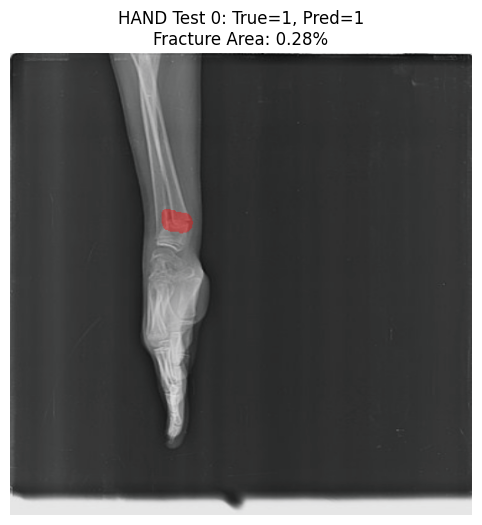

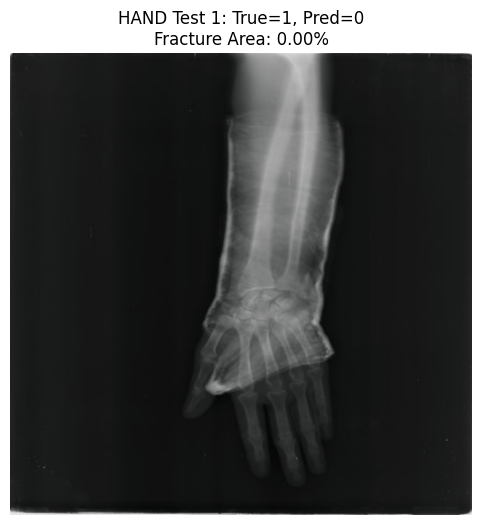

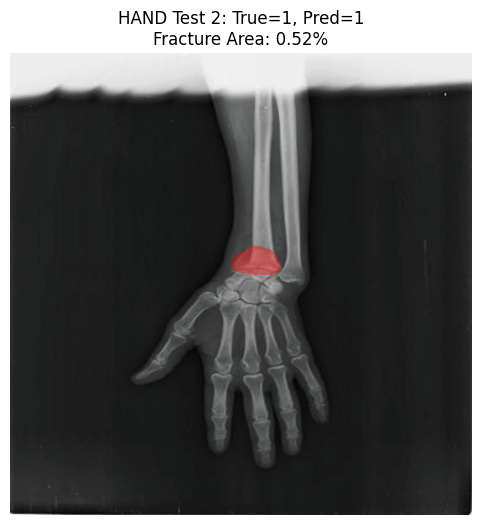

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



=== HAND Î™®Îç∏ ÏÑ±Îä• ===
Confusion Matrix:
[[206  14]
 [ 33  55]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.94      0.90       220
   Fractured       0.80      0.62      0.70        88

    accuracy                           0.85       308
   macro avg       0.83      0.78      0.80       308
weighted avg       0.84      0.85      0.84       308

Accuracy: 84.740%


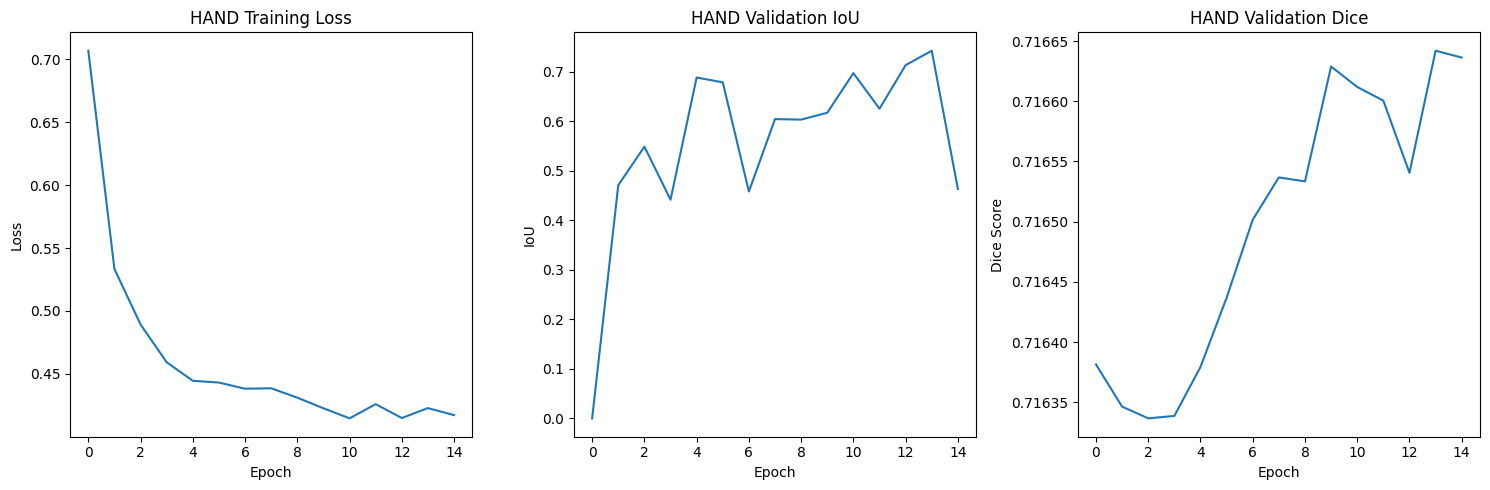

‚úÖ HAND Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏôÑÎ£å!

üè• LEG Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏãúÏûë

=== LEG Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ===
Ï†ÑÏ≤¥ leg Ïù¥ÎØ∏ÏßÄ: 2273Í∞ú
Í≥®Ï†à: 263Í∞ú, Ï†ïÏÉÅ: 2010Í∞ú
Î∂ÑÌï† Í≤∞Í≥º:
  Train: 1363Í∞ú (Í≥®Ï†à: 157Í∞ú)
  Valid: 455Í∞ú (Í≥®Ï†à: 53Í∞ú)
  Test:  455Í∞ú (Í≥®Ï†à: 53Í∞ú)

üöÄ LEG Î∂ÄÏúÑ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 01: Loss 0.3558, Val IoU 0.8835, Val Dice 0.8851


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 02: Loss 0.3312, Val IoU 0.8835, Val Dice 0.8851


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 03: Loss 0.3334, Val IoU 0.8594, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 04: Loss 0.3256, Val IoU 0.8899, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.3406, Val IoU 0.8952, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 06: Loss 0.3201, Val IoU 0.9006, Val Dice 0.8852


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 07: Loss 0.3338, Val IoU 0.8516, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 08: Loss 0.3312, Val IoU 0.8928, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 09: Loss 0.3274, Val IoU 0.8760, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 10: Loss 0.3340, Val IoU 0.9004, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 11: Loss 0.3149, Val IoU 0.9010, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 12: Loss 0.3372, Val IoU 0.8913, Val Dice 0.8853


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 13: Loss 0.3338, Val IoU 0.9015, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 14: Loss 0.3371, Val IoU 0.9015, Val Dice 0.8854


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 15: Loss 0.3217, Val IoU 0.9153, Val Dice 0.8853

üìä LEG Î™®Îç∏ ÌèâÍ∞Ä Ï§ë...


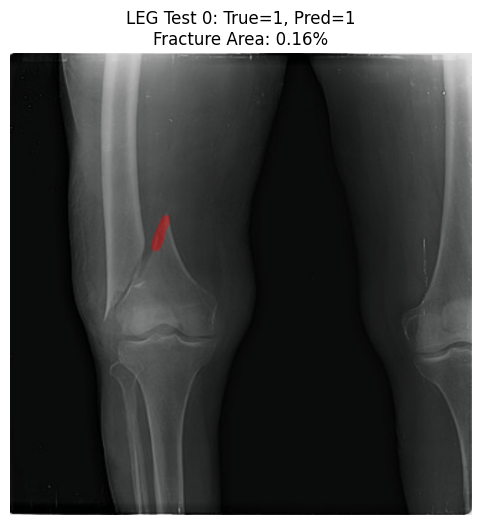

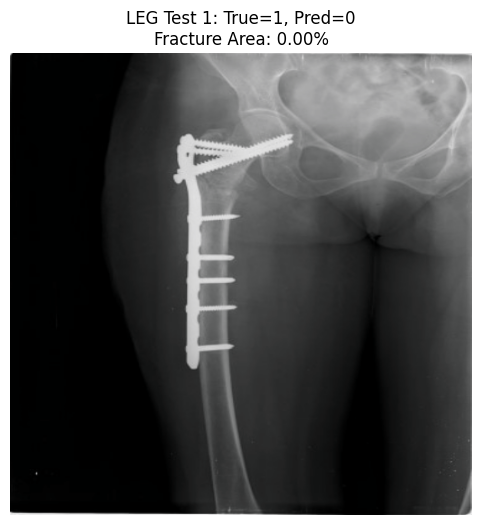

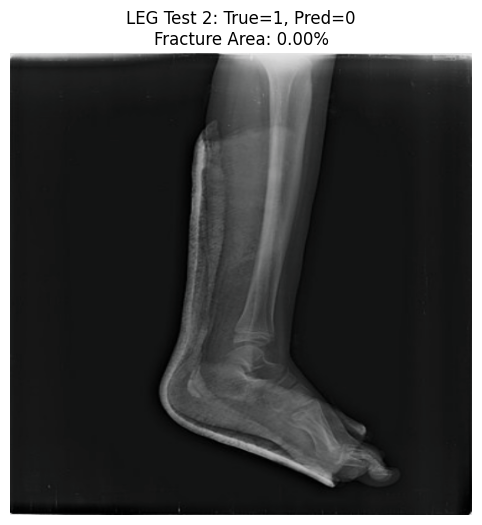

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



=== LEG Î™®Îç∏ ÏÑ±Îä• ===
Confusion Matrix:
[[400   2]
 [ 26  27]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       402
   Fractured       0.93      0.51      0.66        53

    accuracy                           0.94       455
   macro avg       0.94      0.75      0.81       455
weighted avg       0.94      0.94      0.93       455

Accuracy: 93.846%


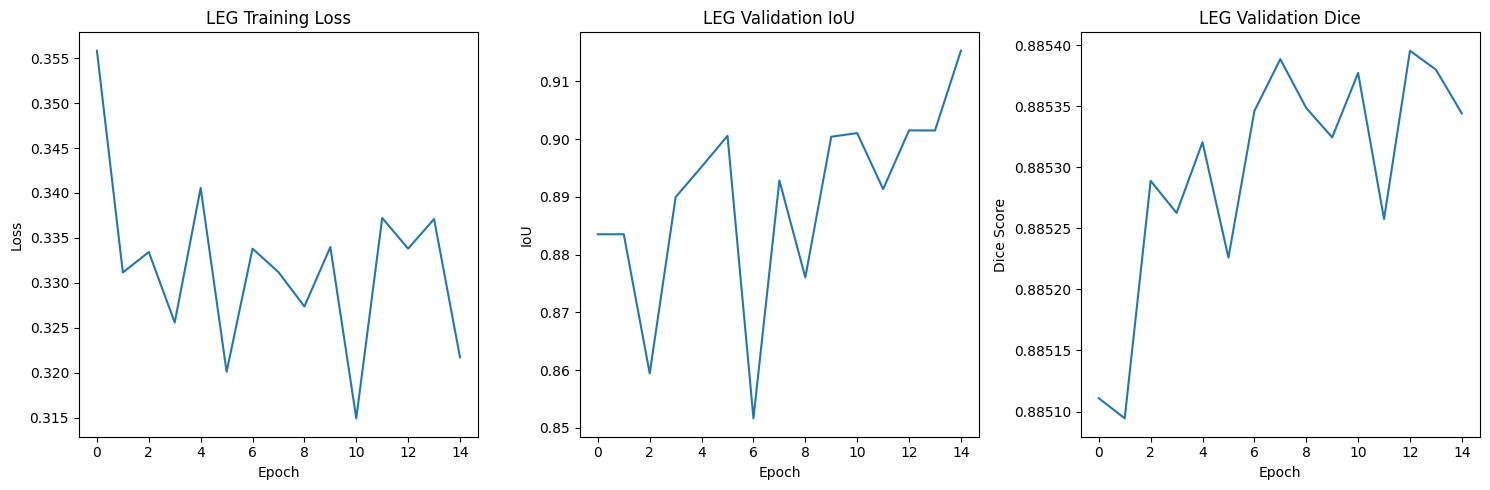

‚úÖ LEG Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏôÑÎ£å!

üè• HIP Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏãúÏûë

=== HIP Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ===
Ï†ÑÏ≤¥ hip Ïù¥ÎØ∏ÏßÄ: 338Í∞ú
Í≥®Ï†à: 63Í∞ú, Ï†ïÏÉÅ: 275Í∞ú
Î∂ÑÌï† Í≤∞Í≥º:
  Train: 202Í∞ú (Í≥®Ï†à: 37Í∞ú)
  Valid: 68Í∞ú (Í≥®Ï†à: 13Í∞ú)
  Test:  68Í∞ú (Í≥®Ï†à: 13Í∞ú)

üöÄ HIP Î∂ÄÏúÑ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë
Epoch 01: Loss 0.5969, Val IoU 0.0002, Val Dice 0.8133
Epoch 02: Loss 0.4864, Val IoU 0.7353, Val Dice 0.8133
Epoch 03: Loss 0.4384, Val IoU 0.8088, Val Dice 0.8133
Epoch 04: Loss 0.4765, Val IoU 0.7941, Val Dice 0.8133


Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.4161, Val IoU 0.7500, Val Dice 0.8133
Epoch 06: Loss 0.4199, Val IoU 0.7941, Val Dice 0.8133
Epoch 07: Loss 0.4273, Val IoU 0.7353, Val Dice 0.8133


Premature end of JPEG file


Epoch 08: Loss 0.4289, Val IoU 0.8088, Val Dice 0.8133
Epoch 09: Loss 0.3846, Val IoU 0.8088, Val Dice 0.8134
Epoch 10: Loss 0.3882, Val IoU 0.7794, Val Dice 0.8135


Premature end of JPEG file


Epoch 11: Loss 0.4160, Val IoU 0.8088, Val Dice 0.8134


Premature end of JPEG file


Epoch 12: Loss 0.4134, Val IoU 0.8088, Val Dice 0.8133


Premature end of JPEG file


Epoch 13: Loss 0.4114, Val IoU 0.8088, Val Dice 0.8136
Epoch 14: Loss 0.3777, Val IoU 0.8088, Val Dice 0.8136


Premature end of JPEG file


Epoch 15: Loss 0.4156, Val IoU 0.8088, Val Dice 0.8137

üìä HIP Î™®Îç∏ ÌèâÍ∞Ä Ï§ë...


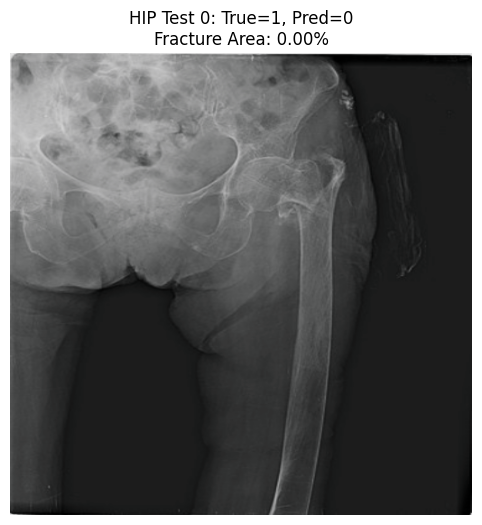

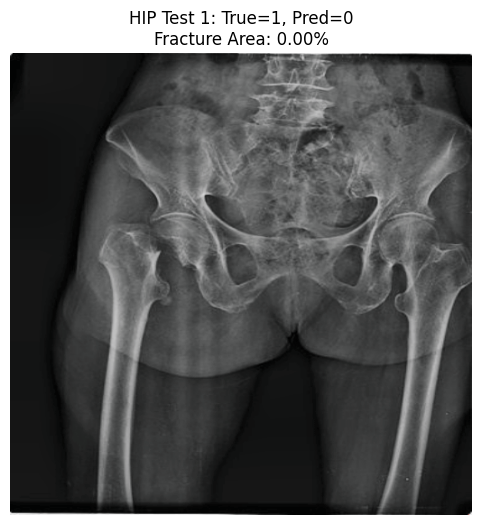

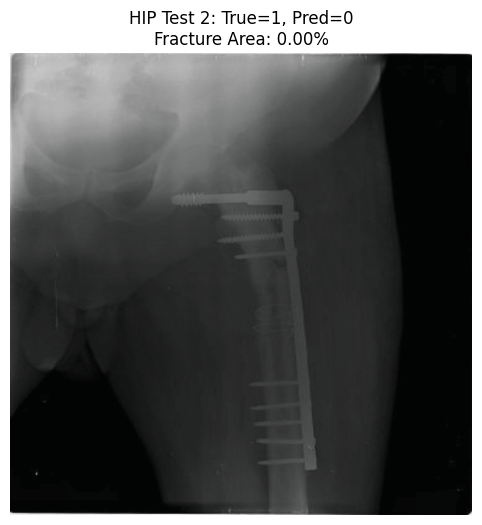


=== HIP Î™®Îç∏ ÏÑ±Îä• ===
Confusion Matrix:
[[55  0]
 [13  0]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.81      1.00      0.89        55
   Fractured       0.00      0.00      0.00        13

    accuracy                           0.81        68
   macro avg       0.40      0.50      0.45        68
weighted avg       0.65      0.81      0.72        68

Accuracy: 80.882%


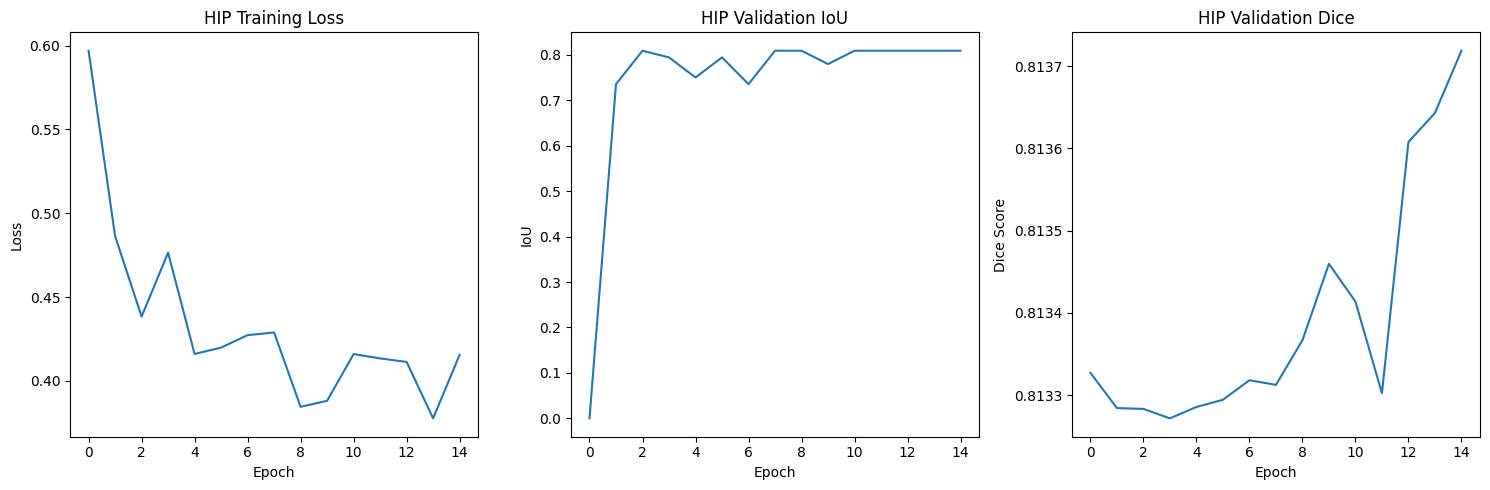

‚úÖ HIP Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏôÑÎ£å!

üè• SHOULDER Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏãúÏûë

=== SHOULDER Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ===
Ï†ÑÏ≤¥ shoulder Ïù¥ÎØ∏ÏßÄ: 349Í∞ú
Í≥®Ï†à: 63Í∞ú, Ï†ïÏÉÅ: 286Í∞ú
Î∂ÑÌï† Í≤∞Í≥º:
  Train: 208Í∞ú (Í≥®Ï†à: 37Í∞ú)
  Valid: 70Í∞ú (Í≥®Ï†à: 13Í∞ú)
  Test:  71Í∞ú (Í≥®Ï†à: 13Í∞ú)

üöÄ SHOULDER Î∂ÄÏúÑ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 01: Loss 0.5438, Val IoU 0.0001, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 02: Loss 0.4596, Val IoU 0.0429, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 03: Loss 0.4370, Val IoU 0.1143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 04: Loss 0.4482, Val IoU 0.1714, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 05: Loss 0.4253, Val IoU 0.4857, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 06: Loss 0.4196, Val IoU 0.6143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 07: Loss 0.4229, Val IoU 0.6571, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 08: Loss 0.4116, Val IoU 0.4143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 09: Loss 0.3934, Val IoU 0.7286, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 10: Loss 0.3833, Val IoU 0.5714, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file


Epoch 11: Loss 0.4045, Val IoU 0.8143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file


Epoch 12: Loss 0.3951, Val IoU 0.8143, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 13: Loss 0.4321, Val IoU 0.7714, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 14: Loss 0.3924, Val IoU 0.7857, Val Dice 0.8156


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 15: Loss 0.3990, Val IoU 0.8000, Val Dice 0.8156

üìä SHOULDER Î™®Îç∏ ÌèâÍ∞Ä Ï§ë...


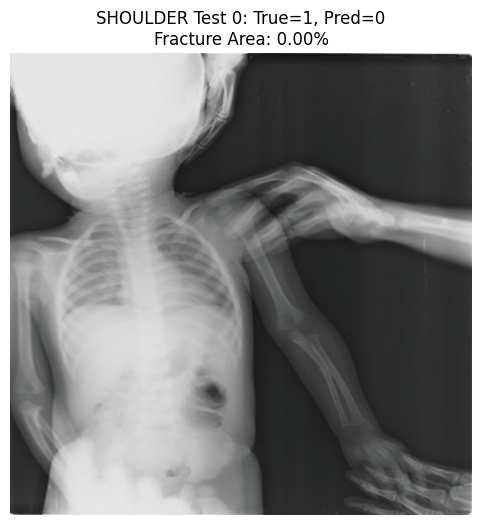

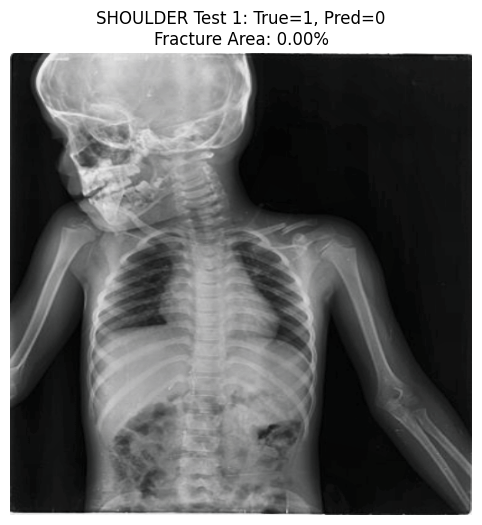

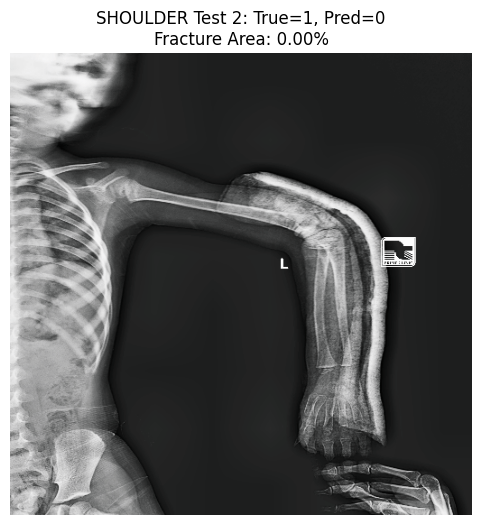

Premature end of JPEG file



=== SHOULDER Î™®Îç∏ ÏÑ±Îä• ===
Confusion Matrix:
[[58  0]
 [13  0]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90        58
   Fractured       0.00      0.00      0.00        13

    accuracy                           0.82        71
   macro avg       0.41      0.50      0.45        71
weighted avg       0.67      0.82      0.73        71

Accuracy: 81.690%


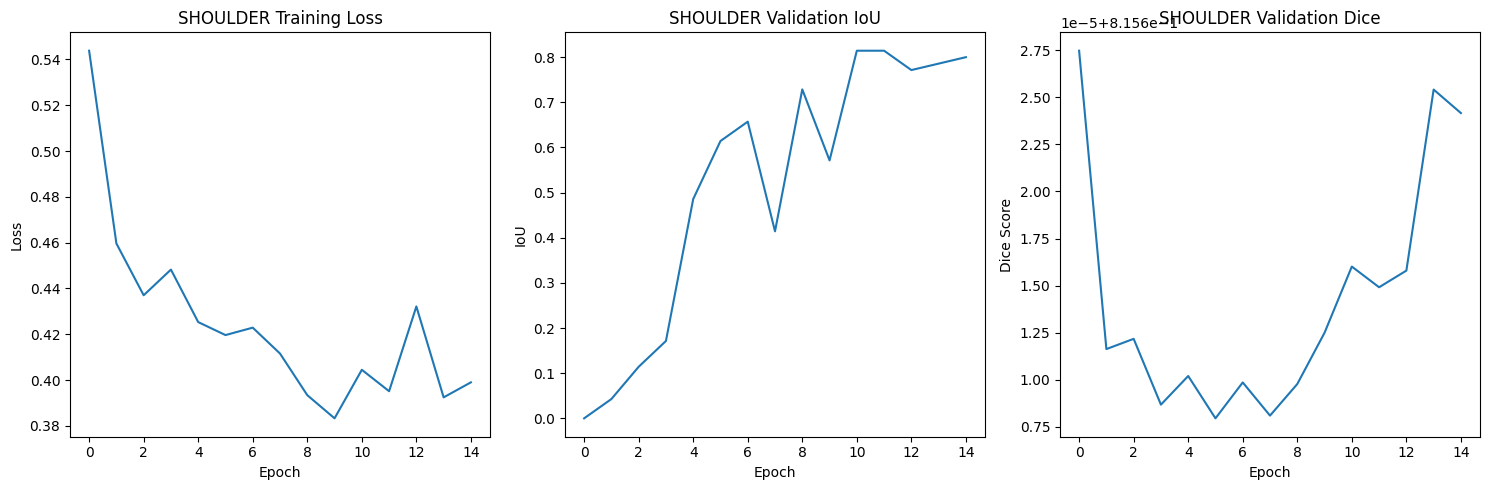

‚úÖ SHOULDER Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏôÑÎ£å!

üéâ Î™®Îì† Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å!


In [ ]:
# Î©îÏù∏ Ïã§Ìñâ: Í∞Å Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌõàÎ†® Î∞è ÌèâÍ∞Ä

body_parts = ['hand', 'leg', 'hip', 'shoulder']
results_summary = {}

for body_part in body_parts:
    try:
        print(f"\n{'='*50}")
        print(f"üè• {body_part.upper()} Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏãúÏûë")
        print(f"{'='*50}")
        
        # 1. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
        train_data, val_data, test_data = create_bodypart_splits(df, body_part)
        
        if train_data is None or len(train_data) < 5:
            print(f"{body_part} Î∂ÄÏúÑÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±Ìï©ÎãàÎã§. Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue
        
        # 2. Î™®Îç∏ ÌõàÎ†®
        model, train_losses, val_ious, val_dices, test_dl = train_bodypart_model(
            body_part, train_data, val_data, test_data
        )
        
        # 3. Î≤†Ïä§Ìä∏ Î™®Îç∏ Î°úÎìú Î∞è ÌèâÍ∞Ä
        model.load_state_dict(torch.load(RESULTS_DIR / f"best_{body_part}_unet.pth"))
        y_true, y_pred = evaluate_bodypart_model(model, test_dl, body_part)
        
        # 4. Í≤∞Í≥º Ï†ÄÏû•
        results_summary[body_part] = {
            'accuracy': accuracy_score(y_true, y_pred),
            'train_samples': len(train_data),
            'val_samples': len(val_data),
            'test_samples': len(test_data),
            'best_val_iou': max(val_ious) if val_ious else 0,
            'best_val_dice': max(val_dices) if val_dices else 0
        }
        
        # 5. ÌõàÎ†® Í≥°ÏÑ† Ï†ÄÏû•
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(train_losses)
        plt.title(f'{body_part.upper()} Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 3, 2)
        plt.plot(val_ious)
        plt.title(f'{body_part.upper()} Validation IoU')
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        
        plt.subplot(1, 3, 3)
        plt.plot(val_dices)
        plt.title(f'{body_part.upper()} Validation Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f'{body_part}_training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"‚úÖ {body_part.upper()} Î∂ÄÏúÑ Ï≤òÎ¶¨ ÏôÑÎ£å!")
        
    except Exception as e:
        print(f"{body_part} Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        continue

print(f"\nÎ™®Îì† Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å!")


üèÜ Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ
          accuracy  train_samples  val_samples  test_samples  best_val_iou  \
hand        0.8474          922.0        308.0         308.0        0.7424   
leg         0.9385         1363.0        455.0         455.0        0.9153   
hip         0.8088          202.0         68.0          68.0        0.8088   
shoulder    0.8169          208.0         70.0          71.0        0.8143   

          best_val_dice  
hand             0.7166  
leg              0.8854  
hip              0.8137  
shoulder         0.8156  


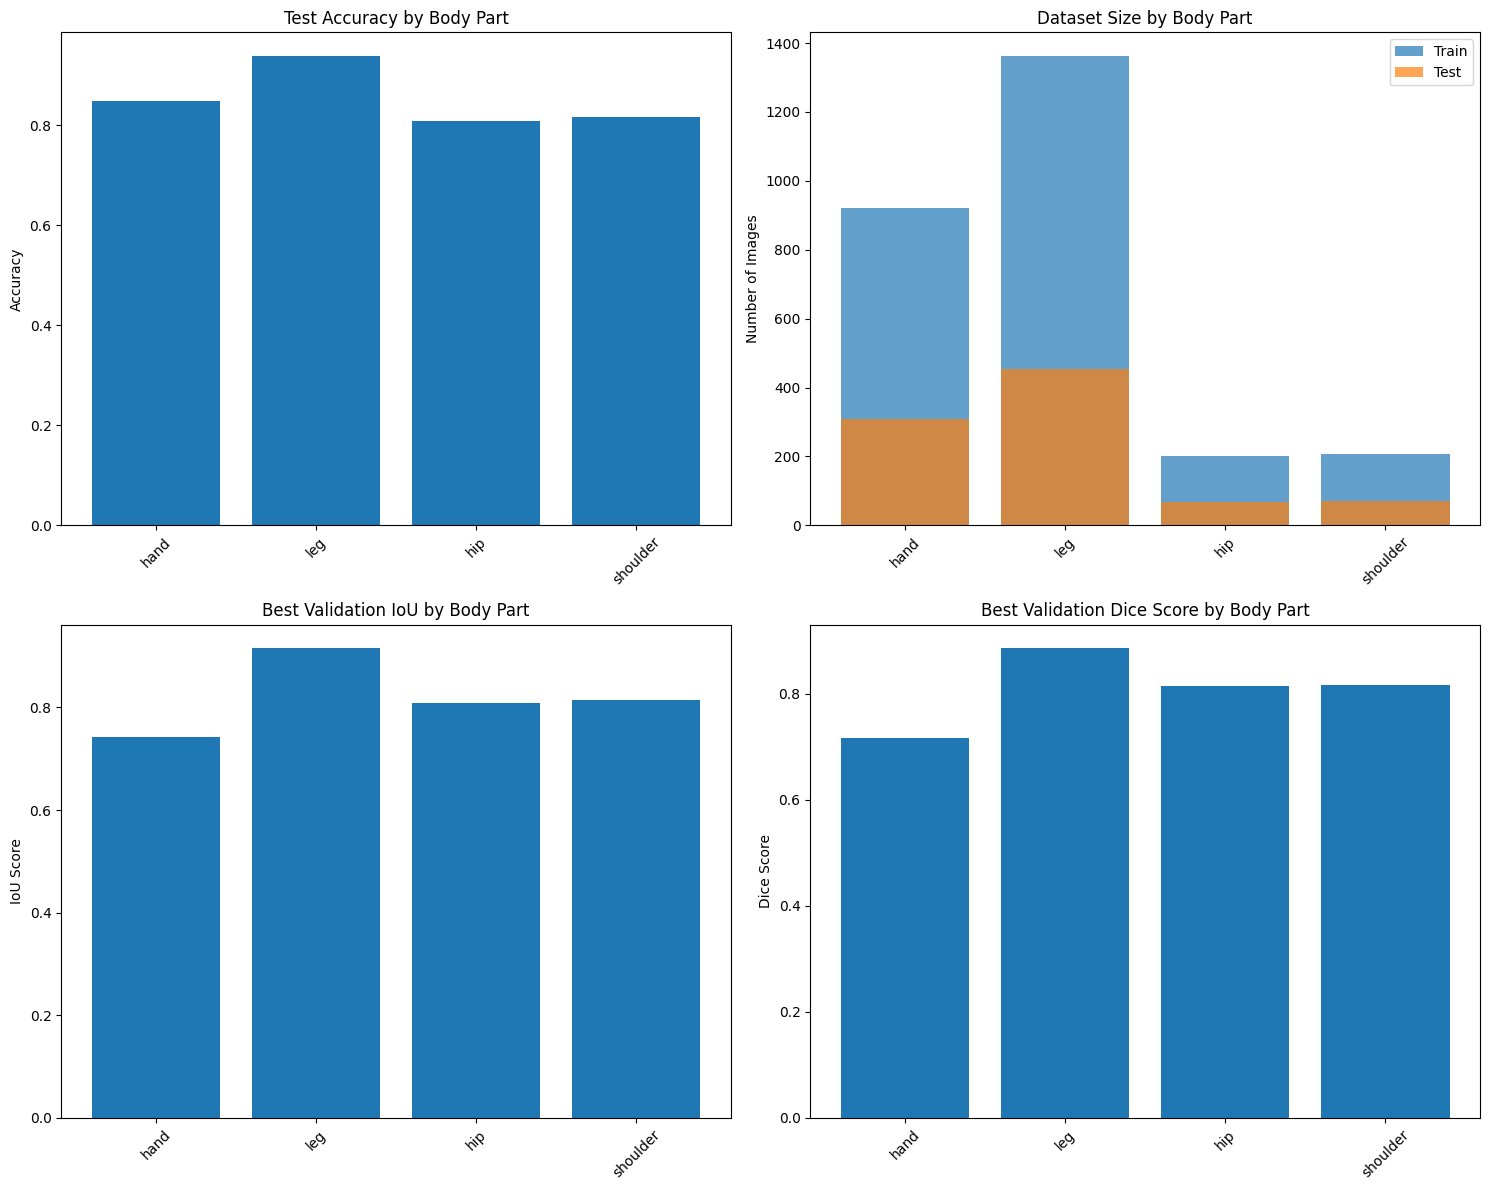


ü•á ÏµúÍ≥† ÏÑ±Îä•:
  Ï†ïÌôïÎèÑ: LEG (93.850%)
  IoU: LEG (0.9153)

üìÅ Î™®Îì† Í≤∞Í≥ºÍ∞Ä /home/a202152010/Í≥®Ï†àÏßÑÎã®/bodypart_resultsÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


In [ ]:
# üìä Ï†ÑÏ≤¥ Í≤∞Í≥º ÏöîÏïΩ Î∞è ÎπÑÍµê

print("\n" + "="*60)
print("Ïã†Ï≤¥ Î∂ÄÏúÑÎ≥Ñ Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ")
print("="*60)

if results_summary:
    summary_df = pd.DataFrame(results_summary).T
    summary_df = summary_df.round(4)
    
    print(summary_df)
    
    # Í≤∞Í≥ºÎ•º CSVÎ°ú Ï†ÄÏû•
    summary_df.to_csv(RESULTS_DIR / 'bodypart_model_summary.csv')
    
    # ÏÑ±Îä• ÎπÑÍµê ÏãúÍ∞ÅÌôî
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Ï†ïÌôïÎèÑ ÎπÑÍµê
    axes[0,0].bar(summary_df.index, summary_df['accuracy'])
    axes[0,0].set_title('Test Accuracy by Body Part')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞ ÎπÑÍµê
    axes[0,1].bar(summary_df.index, summary_df['train_samples'], alpha=0.7, label='Train')
    axes[0,1].bar(summary_df.index, summary_df['test_samples'], alpha=0.7, label='Test')
    axes[0,1].set_title('Dataset Size by Body Part')
    axes[0,1].set_ylabel('Number of Images')
    axes[0,1].legend()
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # IoU ÎπÑÍµê
    axes[1,0].bar(summary_df.index, summary_df['best_val_iou'])
    axes[1,0].set_title('Best Validation IoU by Body Part')
    axes[1,0].set_ylabel('IoU Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Dice Score ÎπÑÍµê
    axes[1,1].bar(summary_df.index, summary_df['best_val_dice'])
    axes[1,1].set_title('Best Validation Dice Score by Body Part')
    axes[1,1].set_ylabel('Dice Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'bodypart_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Î≤†Ïä§Ìä∏ ÏÑ±Îä• Î∂ÄÏúÑ Ï∂úÎ†•
    best_accuracy_part = summary_df['accuracy'].idxmax()
    best_iou_part = summary_df['best_val_iou'].idxmax()
    
    print(f"\nü•á ÏµúÍ≥† ÏÑ±Îä•:")
    print(f"  Ï†ïÌôïÎèÑ: {best_accuracy_part.upper()} ({summary_df.loc[best_accuracy_part, 'accuracy']:.3%})")
    print(f"  IoU: {best_iou_part.upper()} ({summary_df.loc[best_iou_part, 'best_val_iou']:.4f})")
    
else:
    print("ÌõàÎ†®Îêú Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§.")

print(f"\nÎ™®Îì† Í≤∞Í≥ºÍ∞Ä {RESULTS_DIR}Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

## üîç Í≤∞Í≥º Î∂ÑÏÑù Î∞è Í∞úÏÑ† Î∞©Ìñ•

### ÏòàÏÉÅÎêòÎäî Í≤∞Í≥º
1. **LEG Î™®Îç∏**: Í∞ÄÏû• ÎßéÏùÄ Îç∞Ïù¥ÌÑ∞Î°ú Ïù∏Ìï¥ ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä• ÏòàÏÉÅ
2. **HAND Î™®Îç∏**: ÏÉÅÎåÄÏ†ÅÏúºÎ°ú Ï†ÅÏùÄ Îç∞Ïù¥ÌÑ∞Ïù¥ÏßÄÎßå Íµ¨Ï°∞Í∞Ä Îã®ÏàúÌï¥ Ï¢ãÏùÄ ÏÑ±Îä• Í∞ÄÎä•
3. **HIP/SHOULDER Î™®Îç∏**: Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±ÏúºÎ°ú ÏÑ±Îä• Ï†úÌïúÏ†ÅÏùº Ïàò ÏûàÏùå

### Í∞úÏÑ† Î∞©Ìñ•
1. **Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†Ìòï Ìï¥Í≤∞**: 
   - Ï†ÅÏùÄ Î∂ÄÏúÑÏóê ÎåÄÌïú Ï∂îÍ∞Ä Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
   - Îçî Í∞ïÎ†•Ìïú Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Í∏∞Î≤ï Ï†ÅÏö©

2. **Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò ÏµúÏ†ÅÌôî**:
   - Î∂ÄÏúÑÎ≥Ñ ÌäπÏÑ±Ïóê ÎßûÎäî Î™®Îç∏ Íµ¨Ï°∞ Ï°∞Ï†ï
   - Transfer Learning ÏµúÏ†ÅÌôî

3. **ÏïôÏÉÅÎ∏î ÏãúÏä§ÌÖú**:
   - Î∂ÄÏúÑ ÌÉêÏßÄ ‚Üí Ìï¥Îãπ Î∂ÄÏúÑ Ï†ÑÏö© Î™®Îç∏ Ï†ÅÏö©
   - Ïó¨Îü¨ Î∂ÄÏúÑ Î™®Îç∏ Í≤∞Í≥º Ï¢ÖÌï©

4. **ÏûÑÏÉÅ Ï†ÅÏö©**:
   - ÏùòÎ£åÏßÑ ÌîºÎìúÎ∞± Î∞òÏòÅ
   - False Negative ÏµúÏÜåÌôîÏóê Ï§ëÏ†ê